In [2]:
%matplotlib notebook
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *


In [3]:
def graph_weight_matrix(mat, title, v_max=None, ax=None, cmap='hot'):
    ax.clear()
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
    ax.matshow(mat, vmin=0, vmax=v_max if v_max is not None else mat.max(), cmap=cmap) # 'gist_stern'
    ax.set_title(title)
    set_font_size(ax, 14)

In [20]:
def animate(direc, frame_rate, v_max, cmap='hot'):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    plt.ion()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

    for i_f in range(0, len(file_names), frame_rate):
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        if i_f == 0:
            w_r_initial = copy(loaded['w_r_e'])
            
        graph_weight_matrix(loaded['w_r_e'], f'{i_f}', ax=ax, v_max=v_max, cmap=cmap)
        fig.canvas.draw()
        time.sleep(0.000001)
    
    loaded = sio.loadmat(os.path.join(direc, file_names[-1]))
    graph_weight_matrix(loaded['w_r_e'], f'{len(file_names) - 1}', ax=ax, v_max=v_max, cmap=cmap)
    w_r_final = copy(loaded['w_r_e'])
    return w_r_initial, w_r_final
    
    

<IPython.core.display.Javascript object>


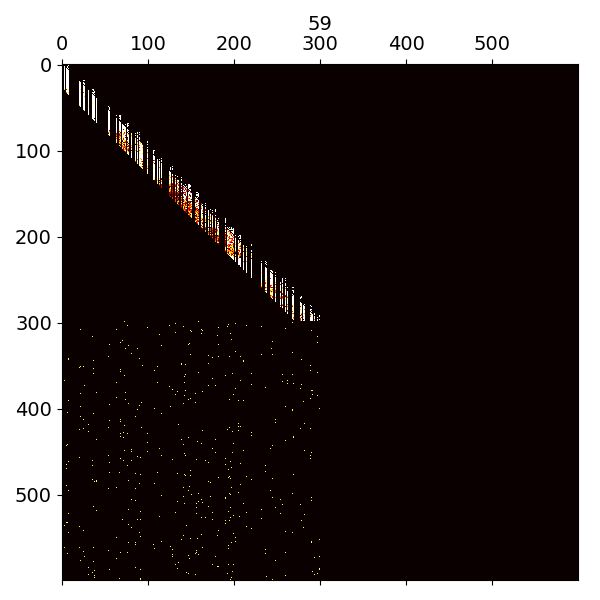

In [21]:
w_r_initial, w_r_final = animate('./data/stability_test_2021-01-20--10:21--32:8342_0_0', 1, 0.26 * 0.004 * .48 / 10, cmap='hot')

In [27]:
def plot_w_r(w_r):
    exc_w_r = w_r[:300, :300]
    incoming_weights = exc_w_r.sum(axis=1)
    fig, ax = plt.subplots(3, 1, figsize=(7, 9), tight_layout=True)
    ax[0].scatter(np.arange(len(incoming_weights)), incoming_weights, s=3)
    ax[0].set_ylabel('Summed Incoming Synapse Strength')

    thresh = 1.5e-5
    thresholded = np.where(exc_w_r > thresh, 1, 0)
    thresholded_exc_w_r = np.where(thresholded, exc_w_r, np.nan)
    counts = np.count_nonzero(thresholded, axis=1)       

    ax[1].fill_between(x=np.arange(len(incoming_weights)),
                   y1=np.nanmean(thresholded_exc_w_r, axis=1) - np.nanstd(thresholded_exc_w_r, axis=1)/np.sqrt(counts),
                   y2=np.nanmean(thresholded_exc_w_r, axis=1) + np.nanstd(thresholded_exc_w_r, axis=1)/np.sqrt(counts),
                    color='red', alpha=0.2)

    ax[1].scatter(np.arange(len(incoming_weights)), np.nanmean(thresholded_exc_w_r, axis=1), s=1, c='red')  
    
    ax[1].set_ylabel('Incoming Individual Synapse Strength')

    ax[2].scatter(np.arange(len(counts)), counts, c='red', s=3)
    ax[2].set_xlabel('Neuron Idx')
    ax[2].set_ylabel('Num Connections over Threshold')

<IPython.core.display.Javascript object>


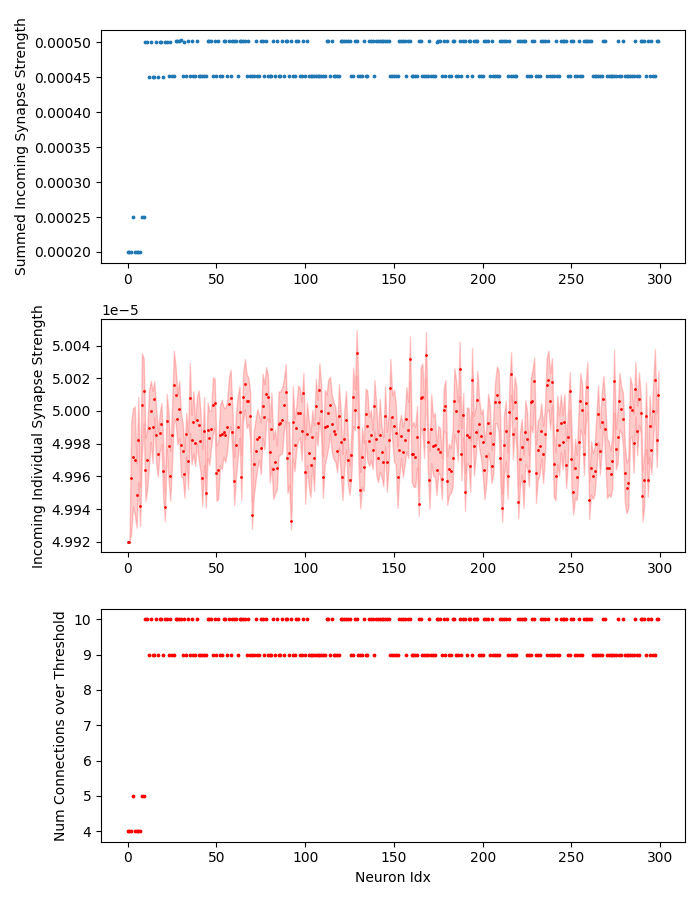

In [28]:
plot_w_r(w_r_initial)

<IPython.core.display.Javascript object>


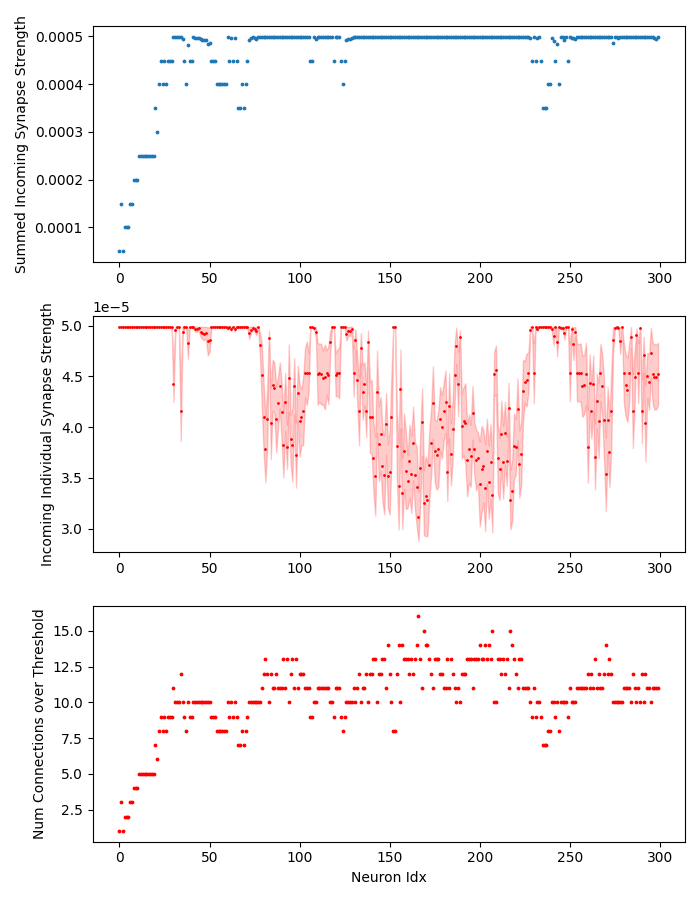

In [29]:
plot_w_r(w_r_final)